## Demonstration of Feature Extraction for Spoken Digits

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook illustrates the engineering of discriminative low-dimensional features for spoken digits. The [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset) (FSDD) is used for the demonstration. Please download/clone the repository before executing this notebook. The features are derived in two stages:

1. The Mel-Frequency Cepstral Coefficients (MFCCs) are computed for each example, and
2. an SVD is applied to the entire dataset to lower the dimensionality of the features.

In [1]:
import glob
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from librosa.feature import mfcc
from sklearn.decomposition import TruncatedSVD

In [2]:
path = '../data/free-spoken-digit-dataset/recordings/'  # path to dataset

### Load Dataset

The FSDD consists of a series of wav files containing recordings of single spoken digits `0-9` for different individuals. Each digit has been recorded multiple times for each individual. In the following, samples of the recordings for the digits `0` and `5` are loaded and normalized.

In [3]:
def load_examples(path, X):
    
    audiofiles = glob.glob(path, recursive=True)
    for filepath in audiofiles:
        x, fs = sf.read(filepath)
        x = x / np.max(np.abs(x))
        X.append(x)
    
    return X, fs

# load examples
X = list()
X, fs = load_examples(path + '0_*.wav', X)
X, _ = load_examples(path + '5_*.wav', X)

# determine maximum length of the examples
lengths = [len(x) for x in X]
N = np.max(lengths)

# append zeros to examples to equalize lengths
X = [np.concatenate((sample, np.zeros(N - len(sample)))) for sample in X]
X = np.array(X)

In [4]:
print('Total number of examples: {}'.format(len(X)))
print('Number of samples per example: {}'.format(N))

Total number of examples: 600
Number of samples per example: 9341


### Compute MFCCs

The mel-frequency cepstral coefficients (MFCCs) are frequently used in speech processing and recognition. We use the function [`librosa.feature.mfcc`](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html) in order to extract this feature for the spoken digits.

In [5]:
MFCC = [mfcc(y=sample, sr=fs, htk=True) for sample in X]
MFCC = np.array(MFCC)
MFCC = MFCC.reshape((-1, np.prod(MFCC.shape[1:])))

print('Total number of examples: {}'.format(MFCC.shape[0]))
print('Dimension of feature vectors: {}'.format(MFCC.shape[1]))

Total number of examples: 600
Dimension of feature vectors: 380


### Dimensionality Reduction

The dimensionality of the feature vectors is very high. In order to lower the dimensionality, a SVD is performed on the normalized features.

In [6]:
MFCC = MFCC - np.mean(MFCC, axis=0)

U, S, Vt = np.linalg.svd(MFCC)

Lets inspect the scree plot showing the magnitude of the singular values in order to determine the latent dimensions of the dataset.

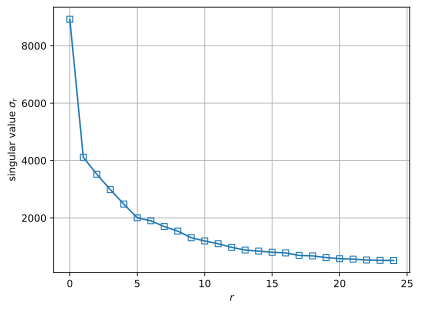

In [7]:
def scree_plot(S):
    '''Plots a scree plot of the eigenvalues.'''
    line, = plt.plot(S, marker='s', markerfacecolor='none')
    plt.xlabel(r'$r$')
    plt.ylabel(r'singular value $\sigma_r$')
    plt.grid()
    
    return line


scree_plot(S[:25])

From the scree plot it seems that $K=6$ is a reasonable choice for the dimensionality of the latent space. We now use a truncated SVD in order to lower the dimensionality of the feature vectors. The truncated SVD is realized by the function [`sklearn.decomposition.TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [8]:
svd = TruncatedSVD(n_components=6)
Xr = svd.fit_transform(MFCC)

print('Total number of examples: {}'.format(Xr.shape[0]))
print('Dimension of reduced feature vectors: {}'.format(Xr.shape[1]))

Total number of examples: 600
Dimension of reduced feature vectors: 6


Lets inspect the reduced dimensionality features by plotting their different sub-dimensions

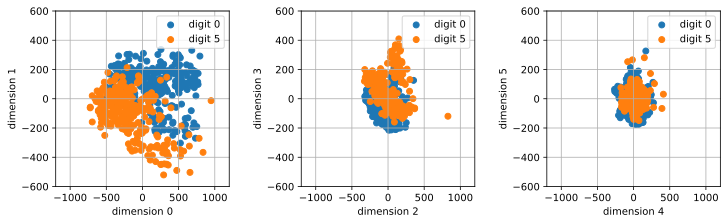

In [9]:
fig = plt.figure(figsize=(10, 3), constrained_layout=True)
gs = fig.add_gridspec(1, 3, wspace=.1)

for n in range(3):
    ax = plt.subplot(gs[n])
    ax.scatter(Xr[:300, 2*n], Xr[:300, 2*n+1], label='digit 0')
    ax.scatter(Xr[300:, 2*n], Xr[300:, 2*n+1], label='digit 5')
    ax.set_xlabel('dimension {}'.format(2*n))
    ax.set_ylabel('dimension {}'.format(2*n+1))
    ax.axis([-1200, 1200, -600, 600])
    ax.grid()
    ax.legend()

### Classification

Inspection of above visualization of the features reveals that the digits `0` and `5` separate quite well in the first two dimensions of this representation. This can be exploited for classification of the spoken digits. A straightforward approach is to fit a linear decision boundary in between the two classes. For instance by visual inspection

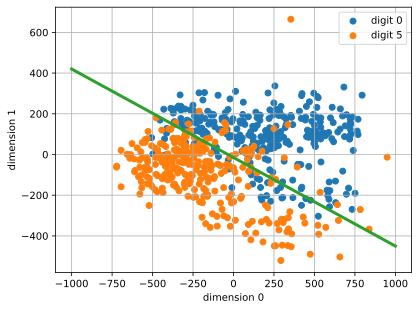

In [10]:
xd = [-1000, 1000]
yd = [420, -450]

plt.scatter(Xr[:300, 0], Xr[:300, 1], label='digit 0')
plt.scatter(Xr[300:, 0], Xr[300:, 1], label='digit 5')
plt.plot(xd, yd, linewidth=3, color='C2')
plt.xlabel('dimension 0')
plt.ylabel('dimension 1')
plt.grid()
plt.legend()

Using this linear decision boundary the classification can be performed and evaluated

In [11]:
# calculate slope and offset of decision boundary
m = (yd[1] - yd[0]) / (xd[1] - xd[0])
a = yd[1] - m * xd[1]

# count correct classifications of digits
count = np.where(Xr[:300,1] > m*Xr[:300, 0]+a)[0].shape[0]
print('Correct classification of spoken digit 0: {} %'.format(count/300*100))
count = np.where(Xr[300:,1] < m*Xr[300:, 0]+a)[0].shape[0]
print('Correct classification of spoken digit 5: {} %'.format(count/300*100))

Correct classification of spoken digit 0: 87.0 %
Correct classification of spoken digit 5: 88.0 %


**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.